# <center> CFRM521 Machine Learning in Finance
## <center> Lecture 5
### <center> Yoshihiro Shirai

# Concepts in Time Series

- These lecture notes are partially based on "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition, by Aurelien Geron (O'Reilly), 2022."

- Chapter 15: Supervised learning for time series data.

#  0. Overview of the lecture

- In this lecture, we discuss how some important concepts apply to classification problems and time series data.

- we explain how this can be transformed into the form where supervised machine learning methods for cross-sectional data can be applied. Specifically, we discuss how to create a test set and do validation.

- This concludes our discussion of the main concepts and steps for supervised learning. In the next lectures, we will discuss particular models for regression and classification in more detail.

# 1. Supervised learning using time series data

- We discuss how to convert time series data into cross-sectional data, which is what we've used up until now. That is, formatting the data as a feature matrix $\mathbf{X}$ and target variable $y$.

- Then we can apply the supervised learning techniques such as linear regression, random forest, etc.

- In this example, let's predict a series $\{r_t\}$. Specifically, $ r_{t+1}$ is predicted based on $r_t,r_{t-1},...,r_{t-k}$.

- For the learning technique to work well, the time series being predicted should be stationary, at least approximately, that is the joint distribution of the observations do not change over time.

- Machine learning methods do not necessarily assume that the time series is stationary, unlike statistical methods such as ARMA models, but will tend to work better on stationary series.

- Some methods to make data stationary include: taking the log returns, taking the difference, subtracting off a deterministic trend.

- The following code simulates the time series we will use in this example.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

np.random.seed(42)
n_steps = 20
series = generate_time_series(10, n_steps)
series = series.ravel()
series_len = series.size

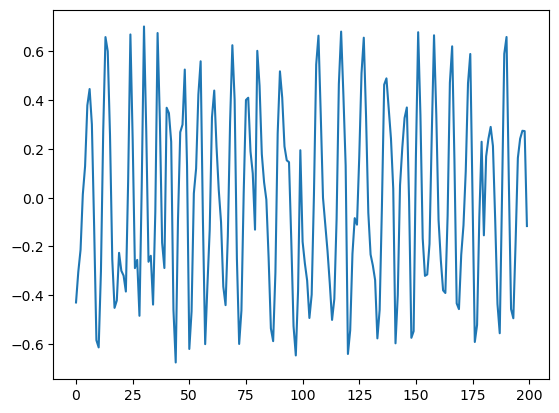

In [3]:
plt.plot(np.array(list(range(series.size))),series)
plt.show()

- We need to create a supervised data out of the time series to train the model. For each time (from time 8 onwards), the value at the last $k=8$ time periods will be used as the features in this example, and the next period's value is the target. In other words, our sample is $\{(\mathbf{x}_t,y_t)\}$ where 
$$\mathbf{x}_t=(r_{t-7},r_{t-6},...,r_t), \quad y_t=r_{t+1}$$

- In this example, the number of lagged values to use $k=8$  is arbitrarily chosen. In practice, a reasonable number of past lags that may affect the forecast should be included, and it can even be selected using a validation set.

- More generally, it is also possible to add additional features to $\mathbf{x}_t$ (e.g. polynomial features, other transformations, technical indicators, etc.) that are known at or before time $t$, and to add features from other time series.

- The following helper function creates this dataset with the features and target out of a given time series.

In [4]:
def ts_split(ts, feature_steps=8, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps]
                  for idx in range(n_obs)])
    return X, y

In [5]:
X, y = ts_split(series, feature_steps=8, target_steps=1)

In [6]:
X.shape

(192, 8)

In [7]:
y.shape

(192, 1)

- Let us check the first observation.

In [8]:
X[0]

array([-0.4295145 , -0.30437034, -0.2137268 ,  0.01376627,  0.12900123,
        0.37884006,  0.44578126,  0.30070013], dtype=float32)

In [9]:
y[0]

array([-0.11990412], dtype=float32)

In [10]:
series[:8]

array([-0.4295145 , -0.30437034, -0.2137268 ,  0.01376627,  0.12900123,
        0.37884006,  0.44578126,  0.30070013], dtype=float32)

- Let us check the last observation as well.

In [11]:
X[-1]

array([ 0.0762936 , -0.45665708, -0.49423882, -0.18364777,  0.16315107,
        0.2418537 ,  0.27457315,  0.27315277], dtype=float32)

In [12]:
y[-1]

array([-0.11622597], dtype=float32)

In [13]:
series[-8:]

array([-0.45665708, -0.49423882, -0.18364777,  0.16315107,  0.2418537 ,
        0.27457315,  0.27315277, -0.11622597], dtype=float32)

- Now we consider some ways of splitting the supervised learning data $\{(\mathbf{x}_t,y_t)\}$ created from the time series.

# 1.1. Training, validation, test set for time series

- Next, we need to create a training and test set. It is necessary to preserve the dependence through time of the time series. In this example, take the first 80% of the observations as the training set and the last 20% as the test set.

In [14]:
split_ind = int(X.shape[0]*0.8)

In [15]:
X_train_full, y_train_full = X[:split_ind], y[:split_ind]
X_test, y_test = X[split_ind:], y[split_ind:]

- If a validation set is needed for hyperparameter tuning or model selection, further split the training set into a training and validation set. Take the first 80% as training and the last 20% as validation

In [16]:
split_ind_2 = int(X_train_full.shape[0]*0.8)

In [17]:
X_train, y_train = X_train_full[:split_ind_2], y_train_full[:split_ind_2]
X_valid, y_valid = X_train_full[split_ind_2:], y_train_full[split_ind_2:]

- We will not do hyperparameter tuning in this example, so we don't need the validation set. The above code is just to show how to make the validation set if needed.

- Next, let us train a linear regression model to predict on the test set.

In [18]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

- Let us evaluate the RMSE of the 1-step ahead forecast on the test set.

In [19]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_test, y_pred))

0.2018977

- To help assess whether to machine learning method is making good prediction, it should be evaulated against a nieve method. For time series data, the nieve method is usually to predict the next value as the previous value or value in the previous seasonal period.

- Predicting the next value as the last values gives higher RSME here.

In [20]:
np.sqrt(np.mean(np.diff(np.concatenate((y_valid[-1],y_test.ravel())))**2))

0.33710784

- The following plots the prediction and the true value on the test set.

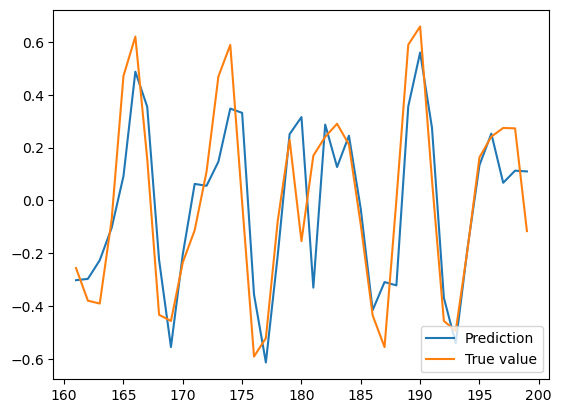

In [21]:
plt.plot(range(series_len-y_test.size,series_len), y_pred, label="Prediction")
plt.plot(range(series_len-y_test.size,series_len), y_test, label="True value")
plt.legend(loc="lower right")
plt.show()

# 1.2. Cross-validation for time series

- The above example used one training, validation and test set. It's also possible to do **cross-validation** for time series so that we have multiple sets, but not using random shuffling for the splits.

- This is also known as **walk forward optimization** and is described in the following diagram (Dixon, Halperin, Bilokon, Machine Learning in Finance: From Theory to Practice, Springer, 2020).

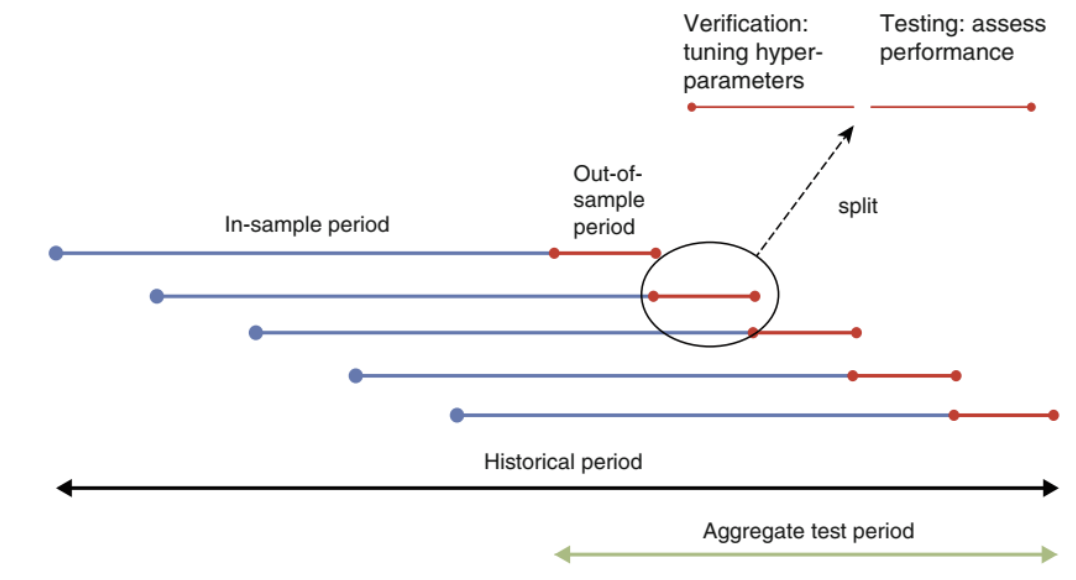

In [22]:
from IPython.display import Image
Image("Figs/TimeSeries-CV.png",width=600)

- Note that in the above diagram:

    - Splitting the test set into a validation and test set is shown, but this is effectively the same as splitting the training set into a training set and a validation set.
    - The starting time of the training set at each fold is shifted forward in time, but we can also use the same starting time for all folds.

- This type of cross-validation split for time series can be obtained using the `TimeSeriesSplit` function.

- A 3-fold CV split is demonstrated below for the sample $\{(\mathbf{x}_t,y_t)\}$ with 12 instances created from a time series as explained in the previous section.

In [23]:
from sklearn.model_selection import TimeSeriesSplit

X_ex = np.random.randn(12, 2)
y_ex = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X_ex):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_ex_train, X_ex_test = X_ex[train_index], X_ex[test_index]
    y_ex_train, y_ex_test = y_ex[train_index], y_ex[test_index]

TRAIN: [0 1 2] TEST: [3 4 5]
TRAIN: [0 1 2 3 4 5] TEST: [6 7 8]
TRAIN: [0 1 2 3 4 5 6 7 8] TEST: [ 9 10 11]


- It is possible to control the size of the training set and the test set using the `max_train_size` and `test_size` arguments.

In [24]:
tscv = TimeSeriesSplit(n_splits=3, test_size=2, max_train_size=4)
for train_index, test_index in tscv.split(X_ex):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_ex_train, X_ex_test = X_ex[train_index], X_ex[test_index]
    y_ex_train, y_ex_test = y_ex[train_index], y_ex[test_index]

TRAIN: [2 3 4 5] TEST: [6 7]
TRAIN: [4 5 6 7] TEST: [8 9]
TRAIN: [6 7 8 9] TEST: [10 11]


# 1.3. Supervised learning for predicting a time series multiple steps ahead

- What if we want to calculate the forecasts 2-step-ahead, 3-step-ahead, and so on?

- There are two usual ways to do this.

- **Recursive**: Use the model we already trained, make it predict the next value, then add that value to the inputs (acting as if this predicted value had actually occurred) while removing the last value, and use the model again to predict the following value to get the 2-step-ahead forecast, and so on. This is iterated to get the other ahead forecasts.

- **Direct**: Train a separate model that takes the last $k$ values to predict the $h$-steps ahead forecast.

- Here, we use the direct method, using the last $k=8$ values as before, to predict the 2-steps ahead forecast

- We need to create the corresponding features and targets. The target from the `ts_split` function is $y_t=(r_{t+1},r_{t+2})$, so we will restrict to the second column which is the target variable for the 2-steps forecast.

In [25]:
X_2ahead, y_2ahead = ts_split(series, feature_steps=8, target_steps=2)

In [26]:
X_2ahead[0]

array([-0.4295145 , -0.30437034, -0.2137268 ,  0.01376627,  0.12900123,
        0.37884006,  0.44578126,  0.30070013], dtype=float32)

In [27]:
y_2ahead[0]

array([-0.11990412, -0.58438444], dtype=float32)

In [28]:
X_2aheadonly = X_2ahead
y_2aheadonly = y_2ahead[:,1]

- In this example, we will combine the methods above:

- A 3-fold time series CV is used, where 50% of the test set is split into a validation set, and the remaining 50% is the test set.

- We train a random forest model.

- The validation sets from the CV are used to tune the hyperparameters `max_depth` over the values (1,2,3) and `n_estimators` over the values (50,100). It is not necessary to understand the model or the hypterparameters yet as this is only an example to show how hyperparameter tuning can be done. The random forest model will be studied in detail in later lectures.

- The best hyperparameters are chosen using RMSE as the performance measure (averaged over the 3 validation sets).

- Unlike with cross-sectional data, it is necessary to write your own code to do CV and hyperparameter tuning for time series data.

In [29]:
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(n_splits=3)

# Hyperparamter combinations
max_depth_list = [1,2,3]
n_estimators_list = [50,100]

def time_series_valid_test(X, y, n_split, valid_or_test, optimal_par=None):
    tscv = TimeSeriesSplit(n_splits=n_split)
    rf_rmse = []
    i = 0
    for train_index, test_index in tscv.split(X):
        i += 1
        # Break test set into 50% validation set, 50% test set
        break_test_ind = int(test_index[0] + 0.5*(test_index[-1]-test_index[0]))
        valid_index = np.array(list(range(test_index[0],break_test_ind)))
        test_index = np.array(list(range(break_test_ind,test_index[-1])))

        # Split
        X_train, X_valid, X_test = X[train_index], X[valid_index], X[test_index]
        y_train, y_valid, y_test = y[train_index], y[valid_index], y[test_index]

        # Tuning
        if valid_or_test == "valid":
            for max_depth in max_depth_list:
                for n_estimators in n_estimators_list:
                    model_rf = RandomForestRegressor(random_state=42, 
                               max_depth=max_depth, n_estimators=n_estimators)
                    model_rf.fit(X_train, y_train.ravel())
                    y_val_rf = model_rf.predict(X_valid)
                    rf_rmse.append(np.sqrt(mean_squared_error(y_valid, y_val_rf)))
        
        # Evalulate on test set
        if valid_or_test == "test":
            model_rf = RandomForestRegressor(random_state=42, 
                       max_depth=optimal_par[0], n_estimators=optimal_par[1])
            model_rf.fit(X_train, y_train.ravel())
            y_test_rf = model_rf.predict(X_test)
            rf_rmse.append(np.sqrt(mean_squared_error(y_test, y_test_rf)))
            
            # Plot the prediction for the last CV fold
            if i == n_split:
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test_rf, label="2-steps ahead prediction")
                plt.plot(range(series_len-test_index.size,series_len),
                         y_test, label="True value")
                plt.legend(loc="upper left")
                plt.show()
    
    # Average RMSE over CV folds
    if valid_or_test == "valid":
        rf_rmse = np.mean(np.array(rf_rmse).reshape(
            n_split, len(max_depth_list)*len(n_estimators_list)), axis=0)
        return rf_rmse
    if valid_or_test == "test":
        rf_rmse = np.mean(rf_rmse)
        return rf_rmse, y_test_rf

- The following results gives the RMSE for each of the hyperparameter combinations (averaged over the 3 validation sets), with the lowest occuring for `max_depth=1` and `n_estimators=100`.

In [30]:
rf_rmse = time_series_valid_test(X_2aheadonly, y_2aheadonly, 3, "valid")
ind = 0
for max_depth in max_depth_list:
        for n_estimators in n_estimators_list:
            print(["(max_depth, n_estimators):",[max_depth, n_estimators]])
            print(rf_rmse[ind])
            ind += 1

['(max_depth, n_estimators):', [1, 50]]
0.2960677367868914
['(max_depth, n_estimators):', [1, 100]]
0.2958489696027136
['(max_depth, n_estimators):', [2, 50]]
0.30680224381182836
['(max_depth, n_estimators):', [2, 100]]
0.30527404004210607
['(max_depth, n_estimators):', [3, 50]]
0.31142296083355747
['(max_depth, n_estimators):', [3, 100]]
0.3088428014846771


- The following evaluates the RMSE on the CV test sets (that is, averaged over the 3 test sets).

- The plot shows the 2-steps ahead prediction and the true value for the test set of the last CV fold.

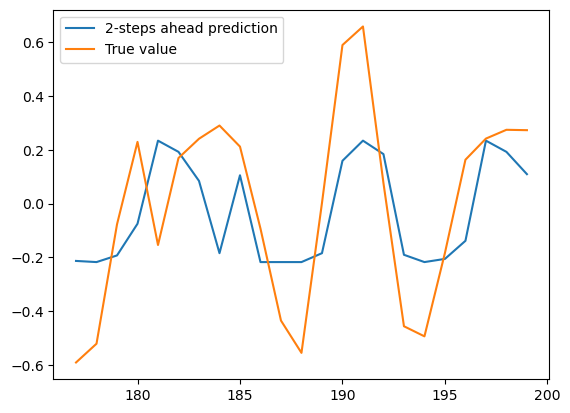

0.3252393948681023

In [31]:
rf_rmse, y_test_rf = time_series_valid_test(X_2aheadonly, y_2aheadonly, 3, "test", [1,100])
rf_rmse

- Lastly, we remark that instead of training a supervised learning model using the sample $\{(\mathbf{x}_t,y_t)\}$ created from a time series, it is possible to instead train a time series model (e.g. an ARIMA model) using the sample $\{r_t\}$ directly.

- Then splitting the data into training, validation and test sets, or using time series CV can be done in a similar way as above.

- We will not do this here, but we will revisit this idea later.